In [1]:
import utils.stan_utility as stan_utility
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import seaborn as sns
import pandas as pd

import scipy.stats as stats

In [2]:
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [3]:
airline_data = pd.read_csv('data.csv', header=0)
print(airline_data)

   Year  Fatal accidents  Passenger deaths  Death rate  \
0  1976               24               734        0.19   
1  1977               25               516        0.12   
2  1978               31               754        0.15   
3  1979               31               877        0.16   
4  1980               22               814        0.14   
5  1981               21               362        0.06   
6  1982               26               764        0.13   
7  1983               20               809        0.13   
8  1984               16               223        0.03   
9  1985               22              1066        0.15   

   Miles flown [100 mln miles]  
0                       3863.0  
1                       4300.0  
2                       5027.0  
3                       5481.0  
4                       5814.0  
5                       6033.0  
6                       5877.0  
7                       6223.0  
8                       7433.0  
9                       7107.0 

### Prior for death rate
We assume that having dearh rate equals 100% would be very improbable. For poisson distribution we have mean of $\lambda$ and standard deviation of $\sqrt{\lambda}$. Approximately in order to have no more than 1% probability $\lambda$ should fulfill

$$\lambda+3\sqrt{\lambda}\approx100 \%$$
We need to assign the prior that would have probability of smaller $\lambda$ equal 99%.

In [4]:
root_of_lam=np.polynomial.polynomial.polyroots([-100.,3.,1.])
lam_ub=np.round(root_of_lam[root_of_lam>0]**2)
print(lam_ub)

[74.]


In [5]:
with open('stan_model/prior_tuning.stan', 'r') as file:
    print(file.read())

functions {
  // Difference between one-sided Gaussian tail probability and target probability
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[1] deltas;
    deltas[1] = 2 * (normal_cdf(theta[1], 0, exp(y[1])) - 0.5) - 0.99;
    return deltas;
  }
}

data {
  vector[1] y_guess; // Initial guess of Gaussian standard deviation
  vector[1] theta;       // Target quantile
}

transformed data {

  vector[1] y;
  real x_r[0];
  int x_i[0];

  // Find Gaussian standard deviation that ensures 99% probabilty below 15
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);

  print("Standard deviation = ", exp(y[1]));
}

generated quantities {
  real sigma = exp(y[1]);
}





In [6]:
tuning = stan_utility.compile_model('stan_model/prior_tuning.stan')

Using cached StanModel


In [7]:
data=dict(y_guess=np.array([np.log(100)]),theta=np.array(lam_ub))
tuned = tuning.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
sigma = np.round(tuned.extract()['sigma'][0])
print(sigma)

29.0


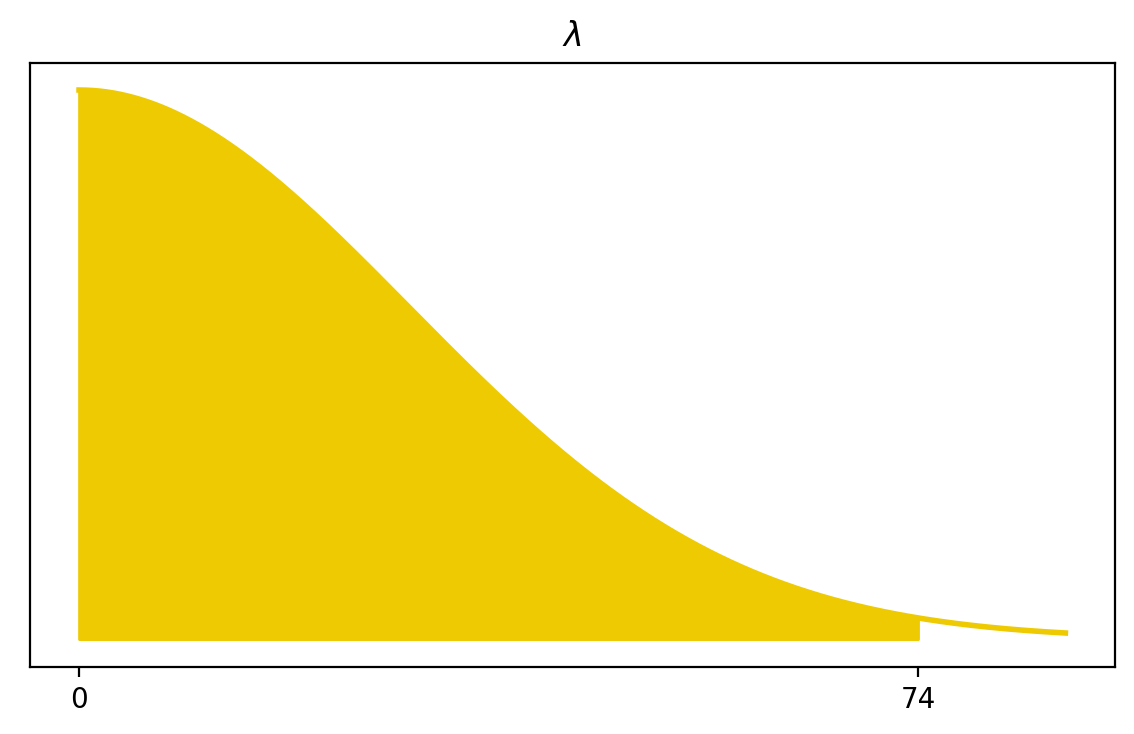

In [8]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,lam_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma),color=dark,linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0,color=dark)
ax2.set_yticks([])
ax2.set_xticks([0,lam_ub[0]])
ax2.set_title(r'$\lambda$')
plt.show()

### Prior predictive distribution
We can use stan to simulate possible outputs and parameteres based only on prior information.

In [9]:
with open('stan_model/airline_deathrate_hn_ppc.stan', 'r') as file:
    print(file.read())

data {
  int sigma; //poisson lambda argument
}


generated quantities {
  real lambda = fabs(normal_rng(0, sigma));
  int y_sim = poisson_rng(lambda);
}





In [10]:
model_prior=stan_utility.compile_model('stan_model/airline_deathrate_hn_ppc.stan')

Using cached StanModel


In [11]:
R = 1000
sim_uf = model_prior.sampling(data={'sigma': int(sigma)},
                            algorithm="Fixed_param",
                            iter=R,
                            warmup=0,
                            chains=1, 
                            refresh=R,
                            seed=29042020)

In [12]:
## generation of vector for plotting samples under histograms
dr=[]
dr_cnt=[]
for k in airline_data['Death rate']:  
    k*=100
    dr_cnt.append(-(1.+dr.count(k)))
    dr.append(int(k))
dr_cnt=np.array(dr_cnt)

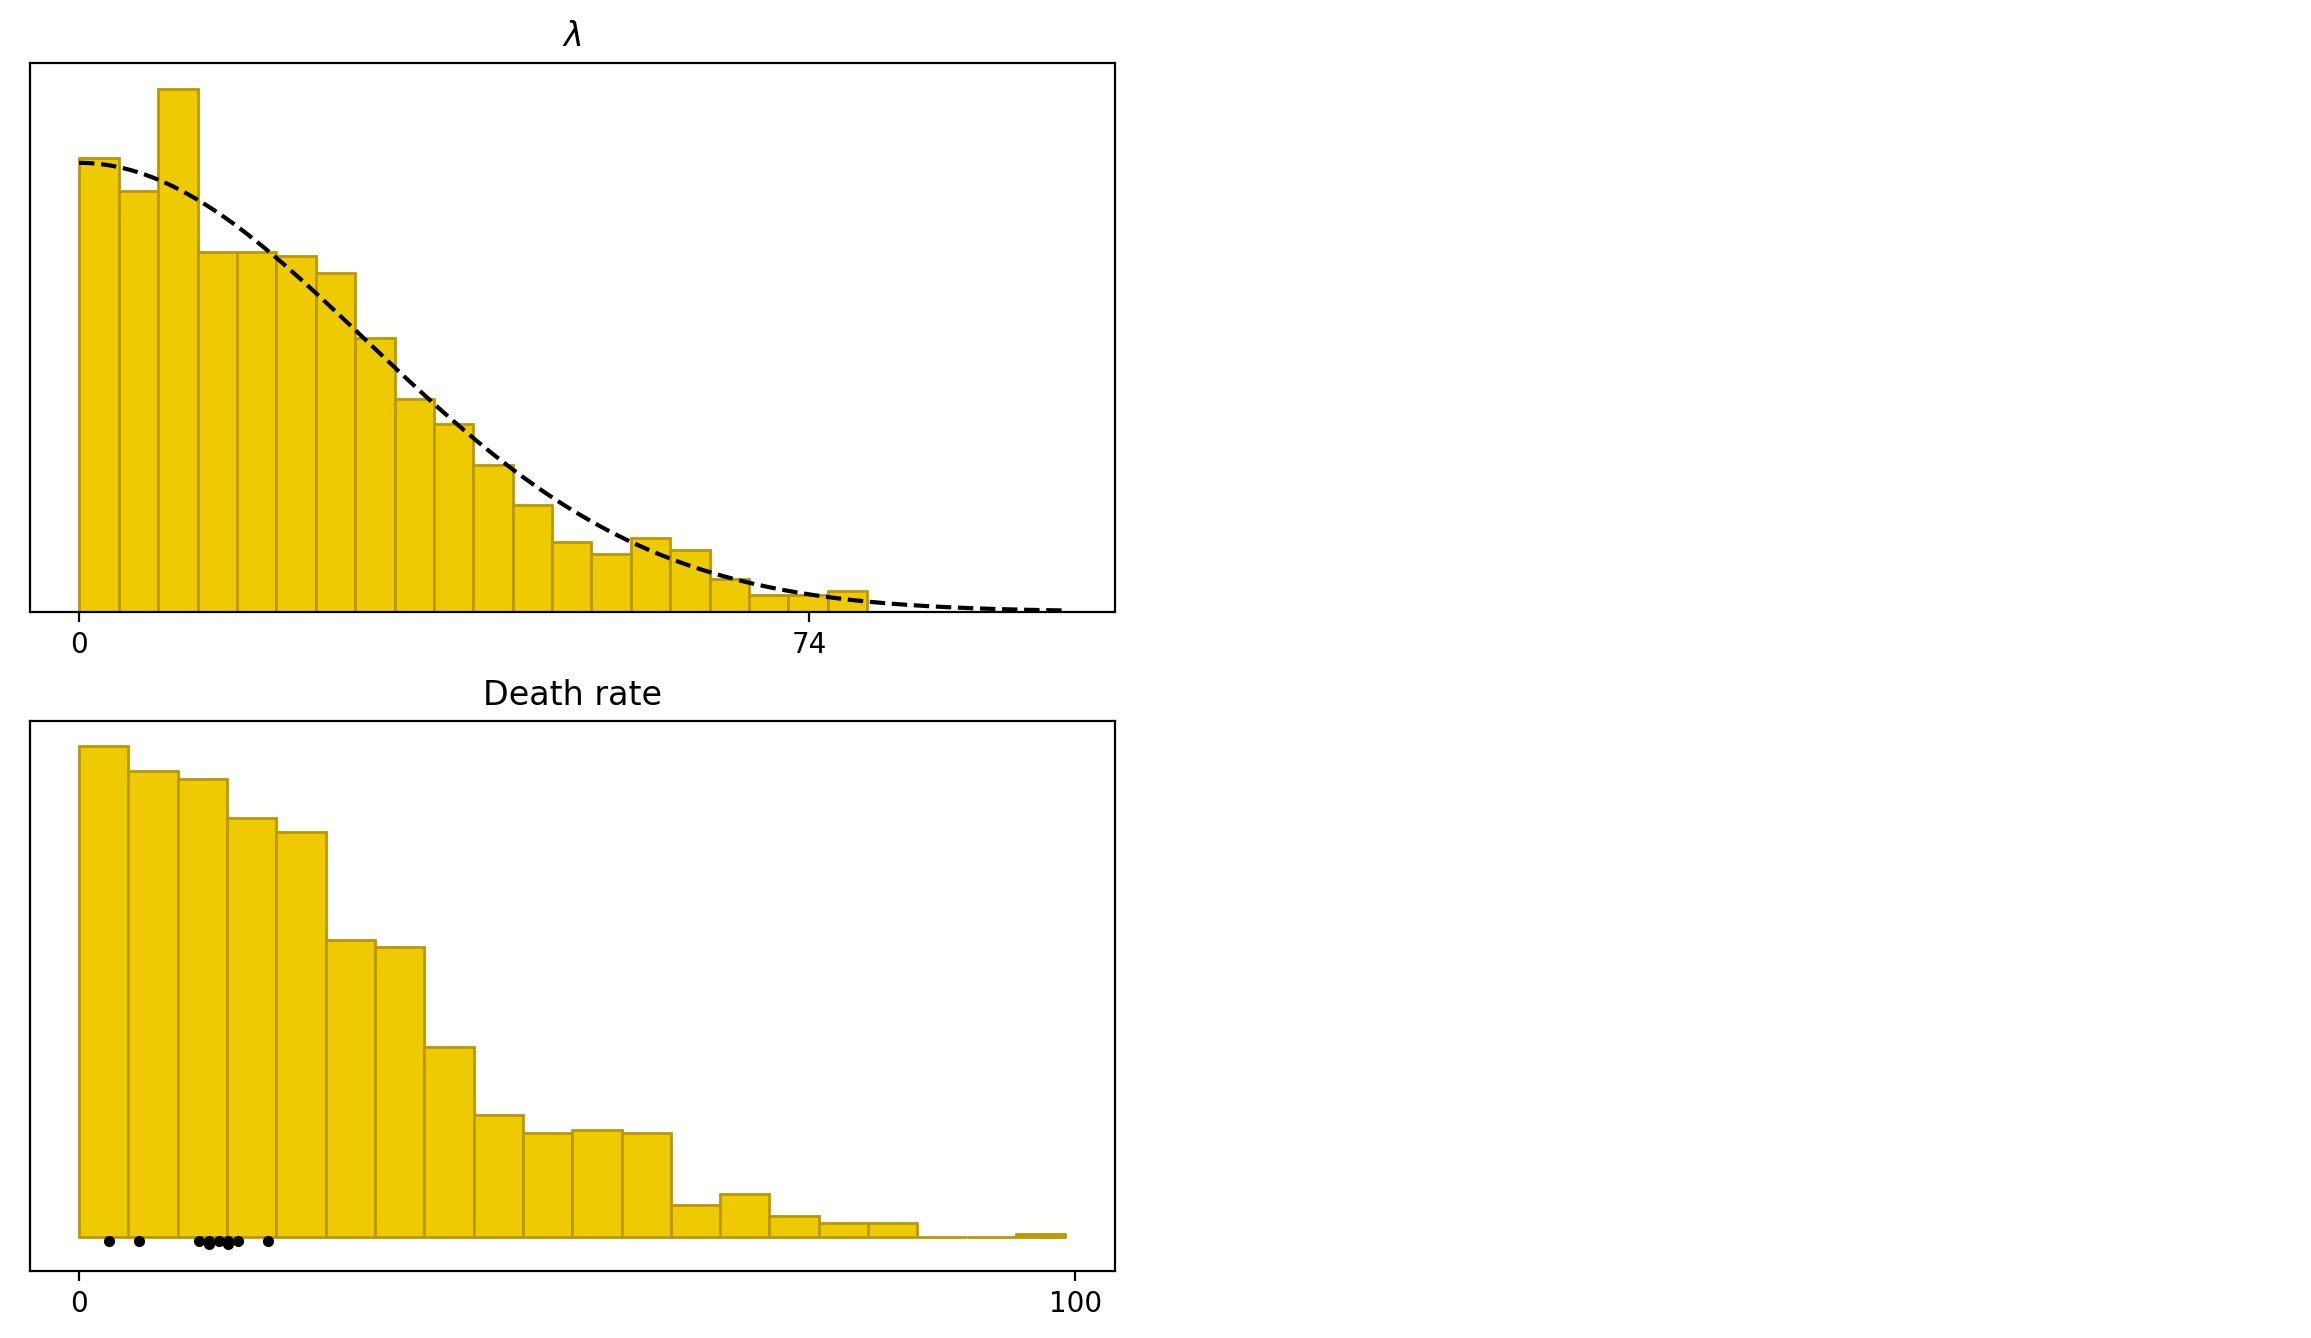

In [13]:
params = sim_uf.extract()
lambda0 = params['lambda']
y_sim = params['y_sim']

fig, axes = plt.subplots(2, 1,figsize=(7, 8))
ax1=axes[0]
ax1.hist(lambda0, bins=20, color=dark, edgecolor=dark_highlight, density=True)
x=np.linspace(0, 100, 2000)
ax1.set_xticks([0, lam_ub[0]])
ax1.set_yticks([])
ax1.set_title(r'$\lambda$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(150,0,sigma)
ax1.annotate('HalfNormal(0,'+str(np.int(sigma))+')',xy=(150,arr_y_loc),xytext=(200,1.5*arr_y_loc),arrowprops={'arrowstyle':'->'})
ax2=axes[1]
ax2.hist(y_sim.flatten(),color=dark,edgecolor=dark_highlight,density=True,bins=20,zorder=1)
ax2.scatter(dr, 0.0002*dr_cnt, color='black', marker='.', zorder=2)
ax2.set_xticks([0, 100])
ax2.set_yticks([])

ax2.set_title('Death rate')
plt.show()

## Posterior inference and posterior predictive checks

In [14]:
with open('stan_model/airline_deathrate_hn_fit.stan', 'r') as file:
    print(file.read())

data {
  int M;    //number of years analyzed
  int y[M]; //death rate in percents 
  int sigma;
}
parameters {
  real<lower=0>lambda;
}
model {
  lambda ~ normal(0, sigma);
  for (k in 1:M) {
    y[k] ~ poisson(lambda);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}



In [15]:
airline_deathrate_fit = stan_utility.compile_model('stan_model/airline_deathrate_hn_fit.stan')

Using cached StanModel


In [16]:
data = dict(M = len(dr),
            y = dr,
            sigma = int(sigma))
fit = airline_deathrate_fit.sampling(data=data, seed=8052020)

params=fit.extract()
lam=params['lambda']
y_sim=params['y_sim']

In [17]:
mean_lam = np.mean(lam)
cinf_lam = az.hpd(lam,0.89)

hpd_width=cinf_lam[1]-cinf_lam[0]

/home/artur/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


In [18]:
print('Mean lambda : {:4.2f}'.format(mean_lam))
print('89% confidence interval: [',*['{:4.2f}'.format(k) for k in cinf_lam],']')

Mean lambda : 12.58
89% confidence interval: [ 10.43 14.60 ]


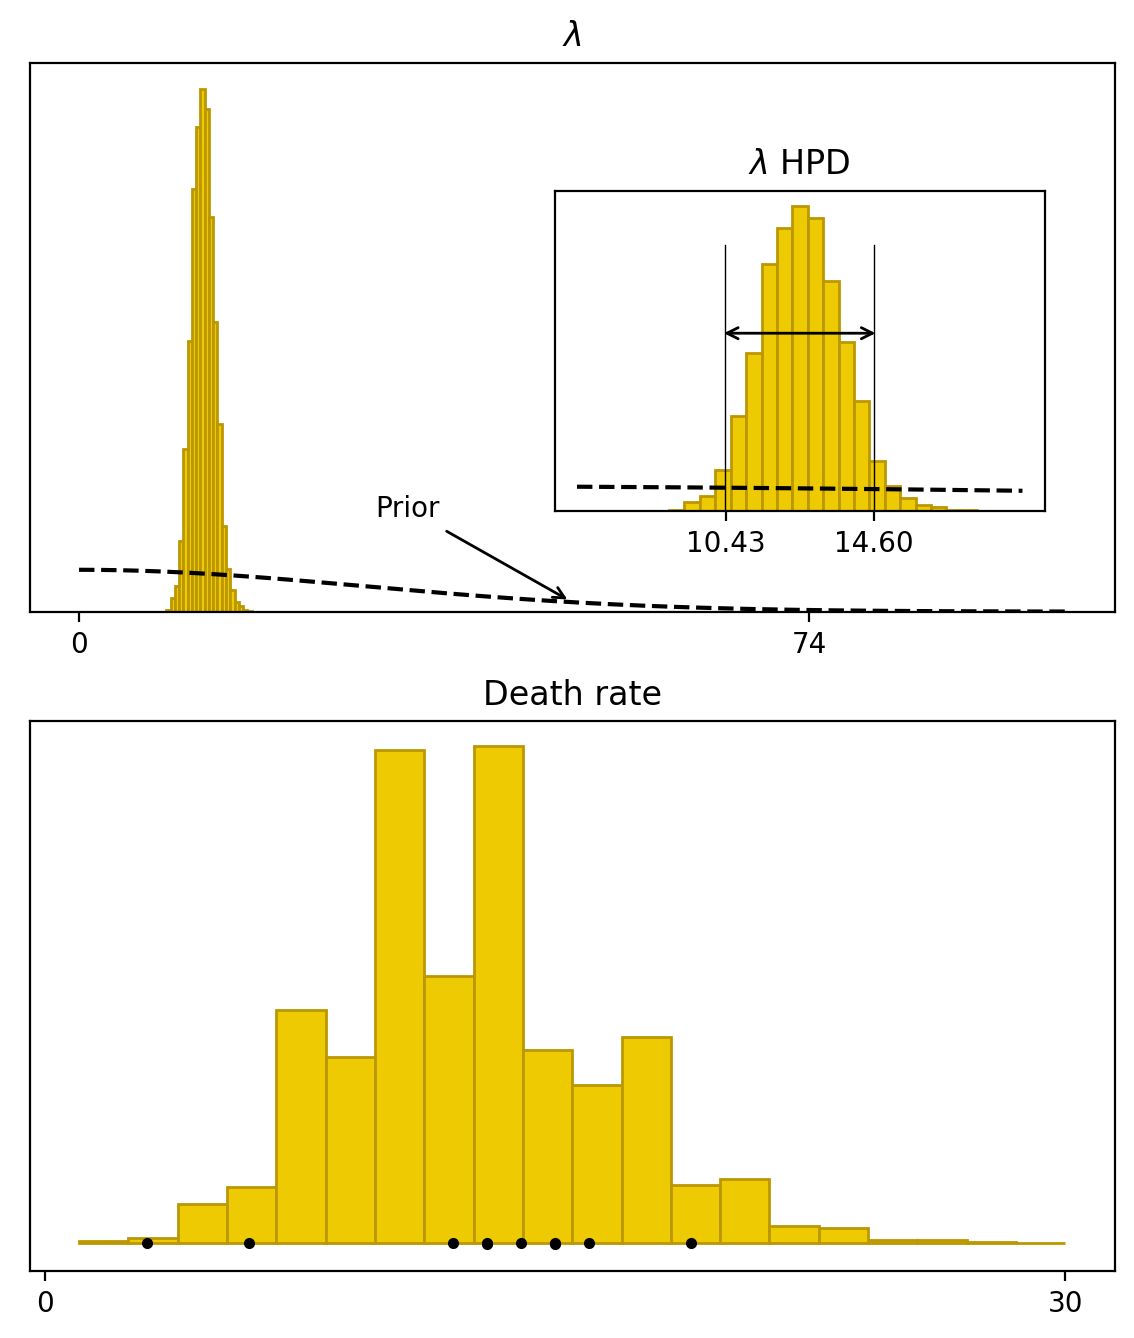

In [19]:
fig, axes = plt.subplots(2, 1,figsize=(7, 8))
ax1=axes[0]
ax1.hist(lam,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,100,1000)
#ax1.plot(x,2*stats.t.pdf(x,5,0,10),color='black',linestyle='--')

ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(50,0,sigma)
ax1.annotate('Prior',xy=(50,arr_y_loc),xytext=(30,10*arr_y_loc),arrowprops={'arrowstyle':'->'})
ax1.set_xticks([0,lam_ub[0]])

ax1.set_yticks([])
ax1.set_title(r'$\lambda$')

ax_sm=plt.axes([0.5,0.6,0.35,0.2])
x_sm=np.linspace(cinf_lam[0]-hpd_width,cinf_lam[1]+hpd_width,200)
ax_sm.hist(lam,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax_sm.plot(x_sm,2*stats.norm.pdf(x_sm,0,sigma),color='black',linestyle='--')
ax_sm.annotate(s='', xy=(cinf_lam[0]-.2,0.2), xytext=(cinf_lam[1]+.2,0.2), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_lam[0],cinf_lam[0]],[0,0.3],color='black',linestyle='-',linewidth=0.5)
ax_sm.plot([cinf_lam[1],cinf_lam[1]],[0,0.3],color='black',linestyle='-',linewidth=0.5)

ax_sm.set_xticks(np.round([cinf_lam[0],cinf_lam[1]],2))
ax_sm.set_yticks([])
ax_sm.set_title(r'$\lambda$ HPD')


ax2=axes[1]
ax2.hist(y_sim.flatten(),color=dark,edgecolor=dark_highlight,density=True,bins=20,zorder=1)
ax2.scatter(dr, 0.0002*dr_cnt, color='black', marker='.', zorder=2)
ax2.set_xticks([0,np.max(y_sim)])
ax2.set_yticks([])

ax2.set_title('Death rate')
plt.show()

In [20]:
airline_data

,Year,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
0,1976,24,734,0.19,3863.0
1,1977,25,516,0.12,4300.0
2,1978,31,754,0.15,5027.0
3,1979,31,877,0.16,5481.0
4,1980,22,814,0.14,5814.0
5,1981,21,362,0.06,6033.0
6,1982,26,764,0.13,5877.0
7,1983,20,809,0.13,6223.0
8,1984,16,223,0.03,7433.0
9,1985,22,1066,0.15,7107.0


### Using model for prediction

In 1983, there were **20** fatal accidents, **809** passenger deaths, and a death rate of **0.13** per 100 million miles flown. Lets check how our can perform such prediction.

In order to predict value in 1983 we just need to use the prior predictive distribution of y_sim.

In [21]:
median_y_sim = np.median(y_sim.flatten())
cinf_y_sim = az.hpd(y_sim.flatten(),0.89)

print('Median of predicted accidents =',median_y_sim)
print('Confidence interval = [',*cinf_y_sim,']')

Median of predicted accidents = 12.0
Confidence interval = [ 6.0 19.0 ]


/home/artur/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


## Modelling for accidents, considering miles

It is rather logical, that number of accidents should be related to number of miles flown. We can still use the Poisson model, however we can decompose rate $\lambda$ into intensity $\theta$ and exposure $n$, i.e.

$$y_i\sim\mathrm{Poisson}(\theta n)$$
With $n$ being a number miles flown (in 100 mil)

### Prior for fatal accidents intensity
We still assume that having death rate equal 100% would be very improbable. Our previous argument, can be still valid, however in order to compute the bound we will use $\lambda=\theta\cdot\bar{n}$, with $\bar{n}$ being mean of miles flown. This gives us condition

$$\theta\cdot\bar{n}+3\sqrt{\theta\cdot\bar{n}}\approx100$$

We need to assign the prior for $\theta$ that would have probability of smaller $\lambda$ equal 99%.

In [22]:
mean_miles=np.mean(airline_data['Miles flown [100 mln miles]'])
root_of_theta=np.polynomial.polynomial.polyroots([-100/mean_miles,3./np.sqrt(mean_miles),1.])
theta_ub=(root_of_theta[root_of_lam>0]**2)
print('theta upper bound','{:4.3f}'.format(theta_ub[0]))

theta upper bound 0.013


In [23]:
data=dict(y_guess=np.array([np.log(0.01)]),theta=np.array(theta_ub))
tuned2 = tuning.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
sigma = (tuned2.extract()['sigma'][0])
print('sigma =','{:4.3f}'.format(sigma))

sigma = 0.005


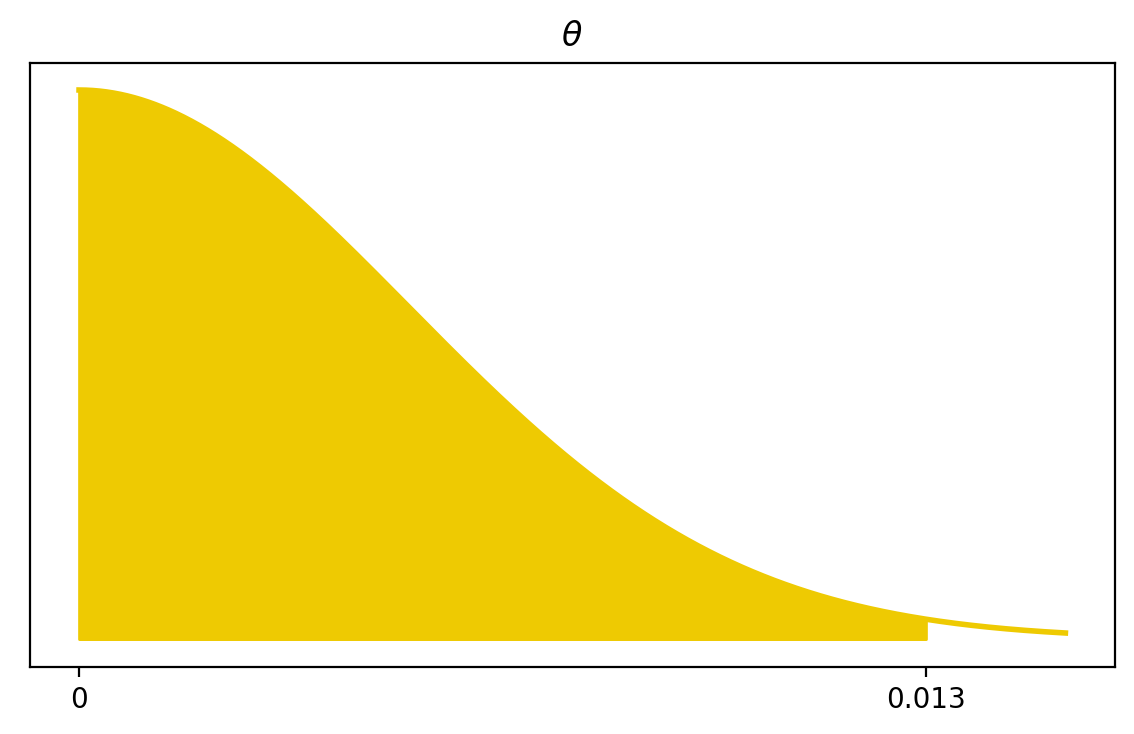

In [24]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,theta_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma),color=dark,linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0,color=dark)
ax2.set_yticks([])
ax2.set_xticks([0,theta_ub[0]])
ax2.set_xticklabels([0,0.013])
ax2.set_title(r'$\theta$')
plt.show()

### Prior predictive distribution

We can use stan to simulate possible outputs and parameteres based only on prior information.


In [25]:
with open('stan_model/airline_miles_hn_ppc.stan', 'r') as file:
    print(file.read())

data {
  int M;            // number of years analyzed
  vector[M] miles;  // number of miles flown each year
  real sigma;       // sigma 
}


generated quantities {
  real theta=fabs(normal_rng(0, sigma));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(theta*miles[k]);
  }
}




In [26]:
model_prior=stan_utility.compile_model('stan_model/airline_miles_hn_ppc.stan')

Using cached StanModel


In [27]:
R=1000
data_prior=dict(M=len(airline_data), miles=airline_data['Miles flown [100 mln miles]'].to_numpy(), sigma=sigma)
sim_uf=model_prior.sampling(data=data_prior,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                     seed=29042020)

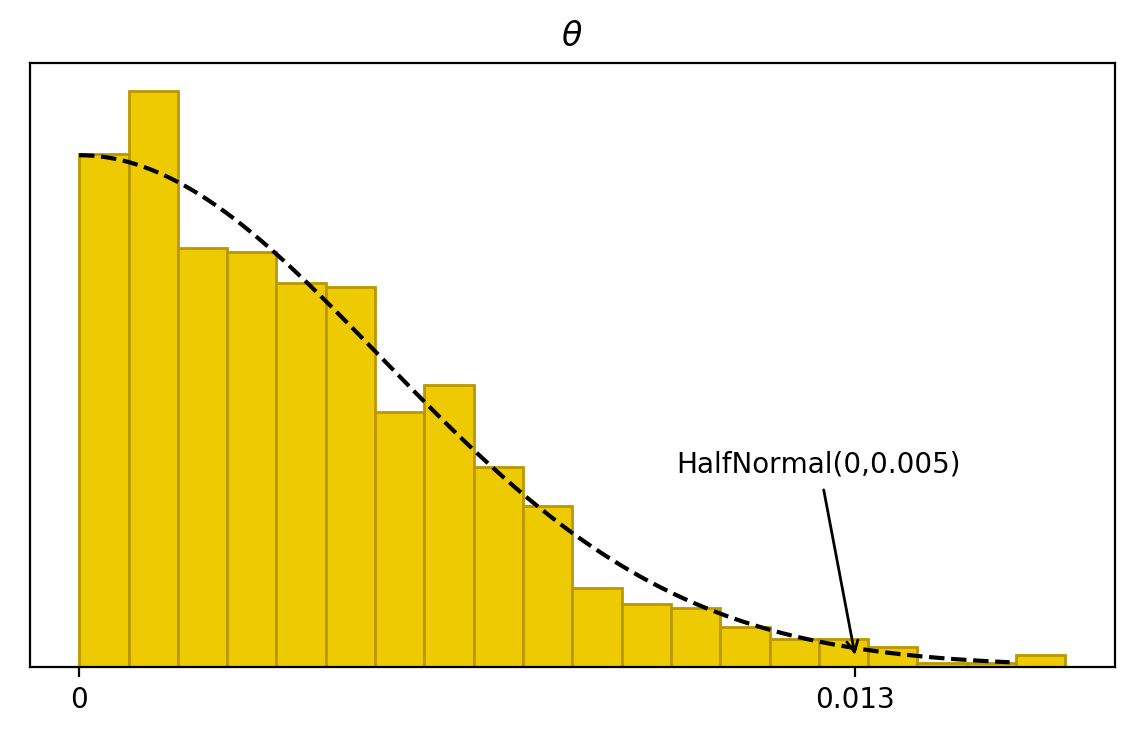

In [28]:
params=sim_uf.extract()
theta=params['theta']

fig, axes = plt.subplots(1, 1,figsize=(7, 4))
ax1=axes
ax1.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,1.2*theta_ub[0],2000)
ax1.set_xticks([0,theta_ub[0]])
ax1.set_xticklabels([0,np.round(theta_ub[0],3)])
ax1.set_yticks([])
ax1.set_title(r'$\theta$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(0.015,0,sigma)
ax1.annotate('HalfNormal(0,'+'{:4.3f}'.format(sigma)+')',xy=(0.013, arr_y_loc),xytext=(0.01, 60),arrowprops={'arrowstyle':'->'})
plt.show()

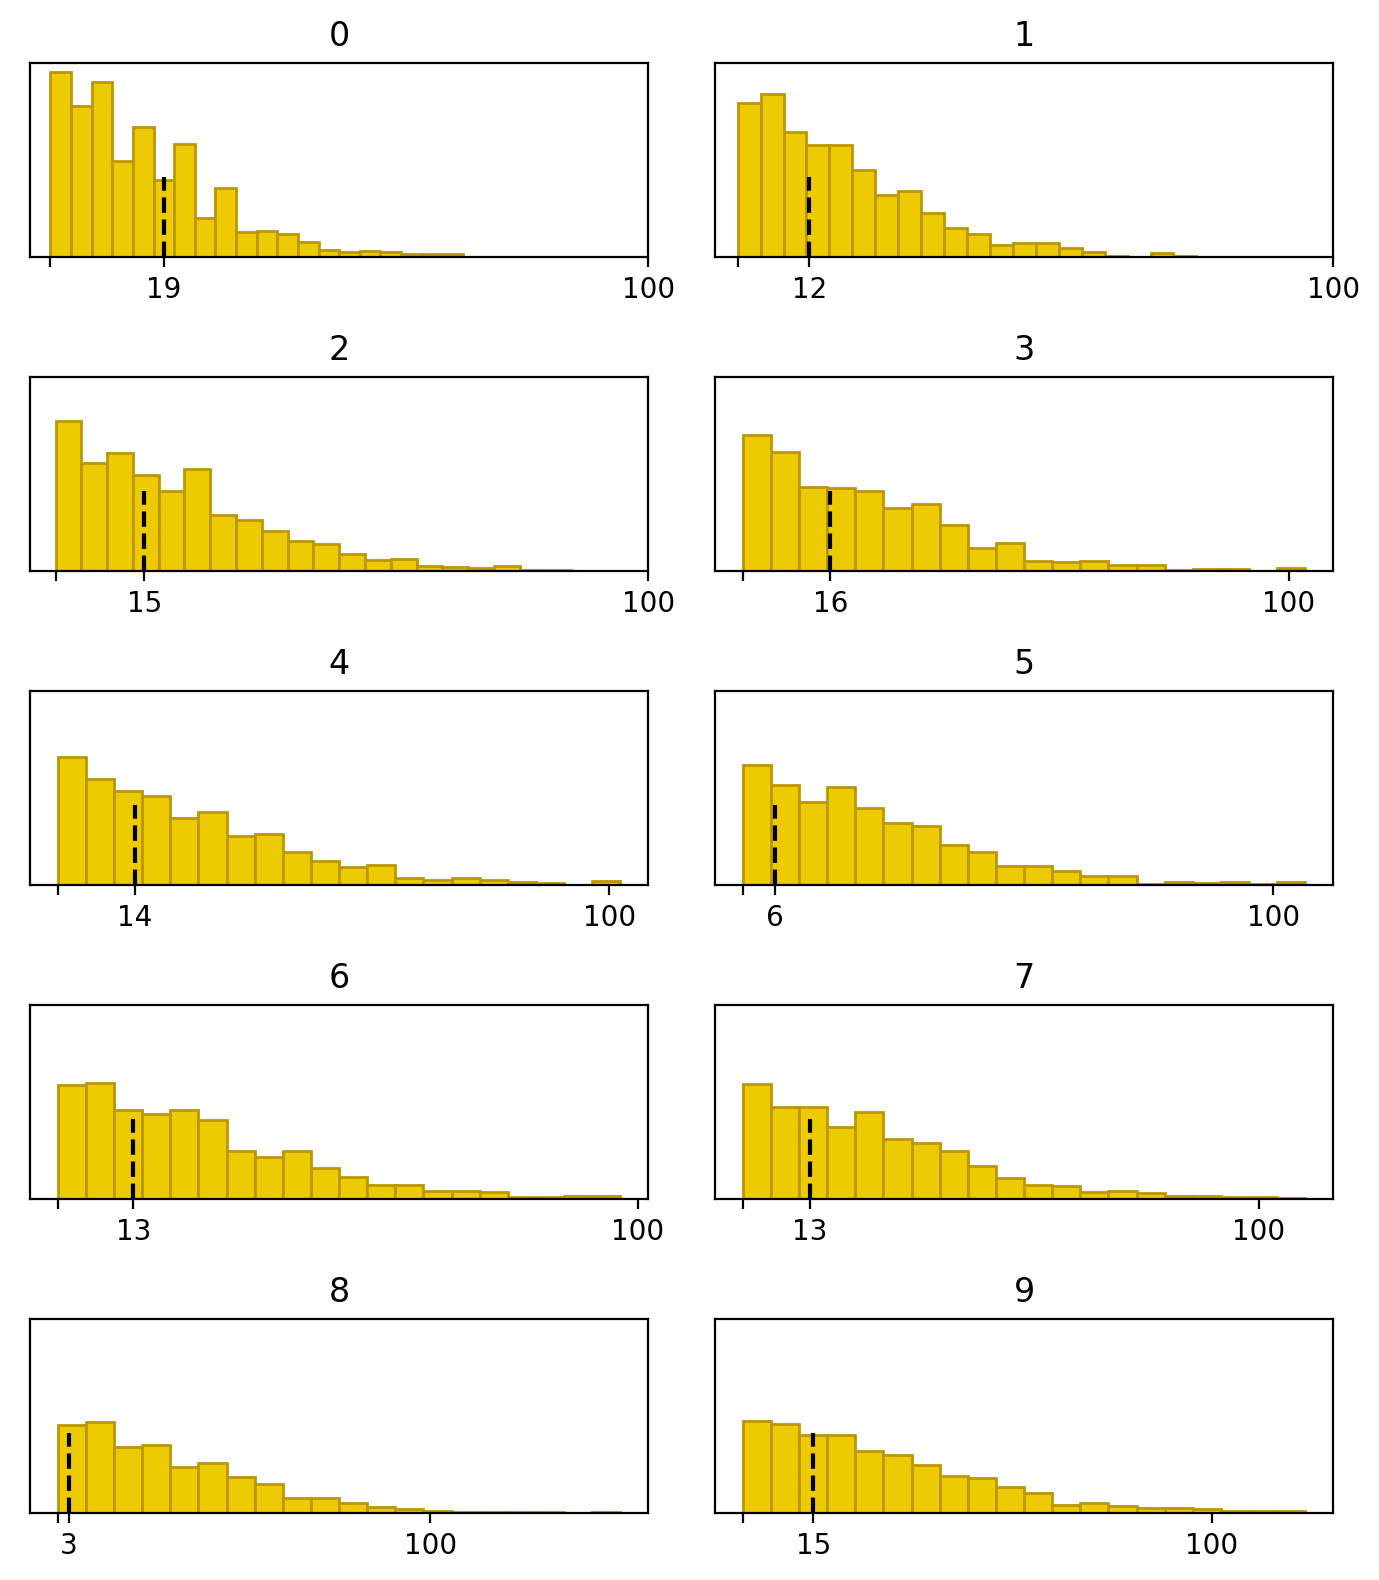

In [35]:
y_sim=params['y_sim']
fig, axes = plt.subplots(5, 2, figsize=(7, 8), sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,color=dark,edgecolor=dark_highlight,density=True)
    ax.set_title(airline_data.index[k])
    tv = int(airline_data['Death rate'].iloc[k]*100)
    ax.plot([tv,tv],[0,0.02],linestyle='--',color='black')
    ax.set_yticks([])
    ax.set_xticks([0,tv,100])
    ax.set_xticklabels(['',tv,100])
#     ax.set_ylim([0,0.012])

fig.tight_layout()

plt.show()

## Posterior inference and posterior predictive checks

In [37]:
with open('stan_model/airline_miles_hn_fit.stan', 'r') as file:
    print(file.read())

data {
  int M;            // number of years analyzed
  vector[M] miles;  // number of miles flown each year
  int y[M];         // death rate in each year
  real sigma;       // sigma
}
parameters {
  real<lower=0>theta;
}
model {
  theta ~ normal(0, sigma);
  for (k in 1:M) {
    y[k] ~ poisson(miles[k]*theta);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(miles[k]*theta);
  }
}




In [38]:
model_miles=stan_utility.compile_model('stan_model/airline_miles_hn_fit.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4101afb69c4b21af85974835a4ace91d NOW.


In [40]:
data = dict(M = len(airline_data),
            miles = airline_data['Miles flown [100 mln miles]'],
            y = dr,
            sigma = sigma)
fit = model_miles.sampling(data=data, seed=8052020)

params_miles=fit.extract()
theta=params_miles['theta']
y_sim=params_miles['y_sim']

In [41]:
mean_theta = np.mean(theta)
cinf_theta = az.hpd(theta,0.89)
hpd_width=cinf_theta[1]-cinf_theta[0]

/home/artur/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


In [42]:
print('Mean theta : {:5.4f}'.format(mean_theta))
print('89% confidence interval: [',*['{:5.4f}'.format(k) for k in cinf_theta],']')

Mean theta : 0.0022
89% confidence interval: [ 0.0019 0.0026 ]


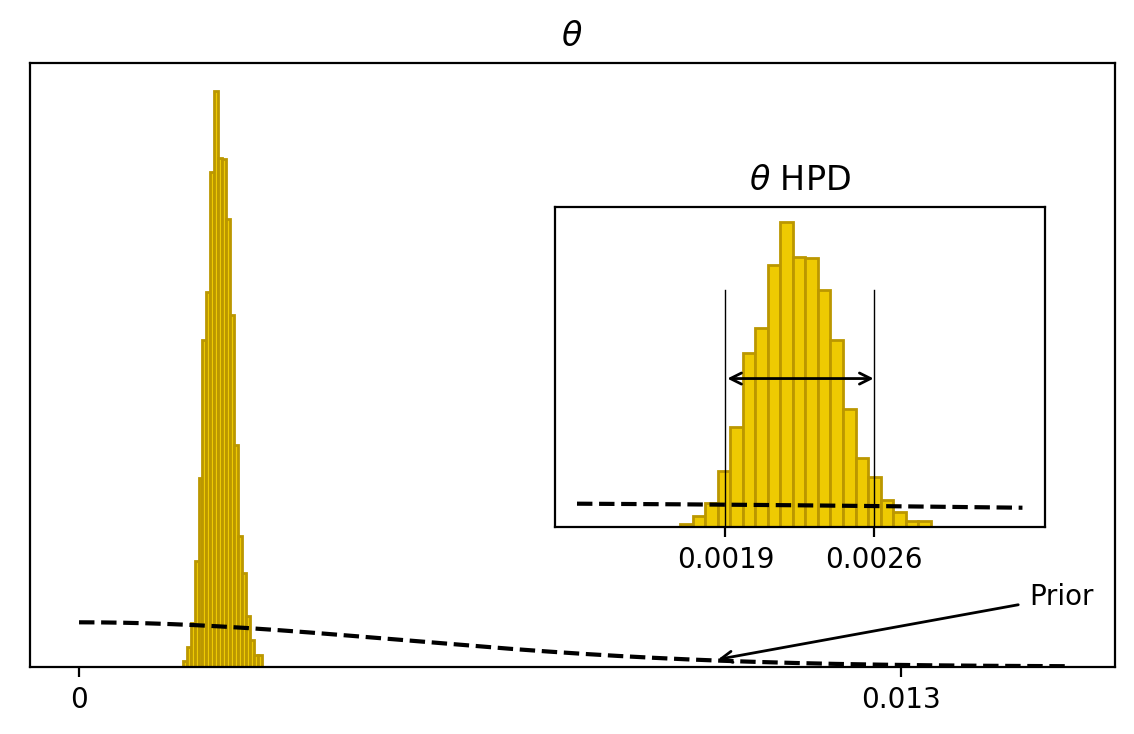

In [43]:
fig, axes = plt.subplots(1, 1,figsize=(7, 4))
ax1=axes
ax1.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,1.2*theta_ub[0],2000)
ax1.set_xticks([0,theta_ub[0]])
ax1.set_xticklabels([0,np.round(theta_ub[0],3)])
ax1.set_yticks([])
ax1.set_title(r'$\theta$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(0.01,0,sigma)
ax1.annotate('Prior',xy=(0.01,arr_y_loc),xytext=(0.015,10*arr_y_loc),arrowprops={'arrowstyle':'->'})

ax_sm=plt.axes([0.5,0.3,0.35,0.4])
x_sm=np.linspace(cinf_theta[0]-hpd_width,cinf_theta[1]+hpd_width,200)
ax_sm.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax_sm.plot(x_sm,2*stats.norm.pdf(x_sm,0,sigma),color='black',linestyle='--')
ax_sm.annotate(s='', xy=(0.99*cinf_theta[0],1000), xytext=(1.01*cinf_theta[1],1000), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_theta[0],cinf_theta[0]],[0,1600],color='black',linestyle='-',linewidth=0.5)
ax_sm.plot([cinf_theta[1],cinf_theta[1]],[0,1600],color='black',linestyle='-',linewidth=0.5)

ax_sm.set_xticks(([cinf_theta[0],cinf_theta[1]]))
ax_sm.set_xticklabels(np.round([cinf_theta[0],cinf_theta[1]],4))

ax_sm.set_yticks([])
ax_sm.set_title(r'$\theta$ HPD')

plt.show()

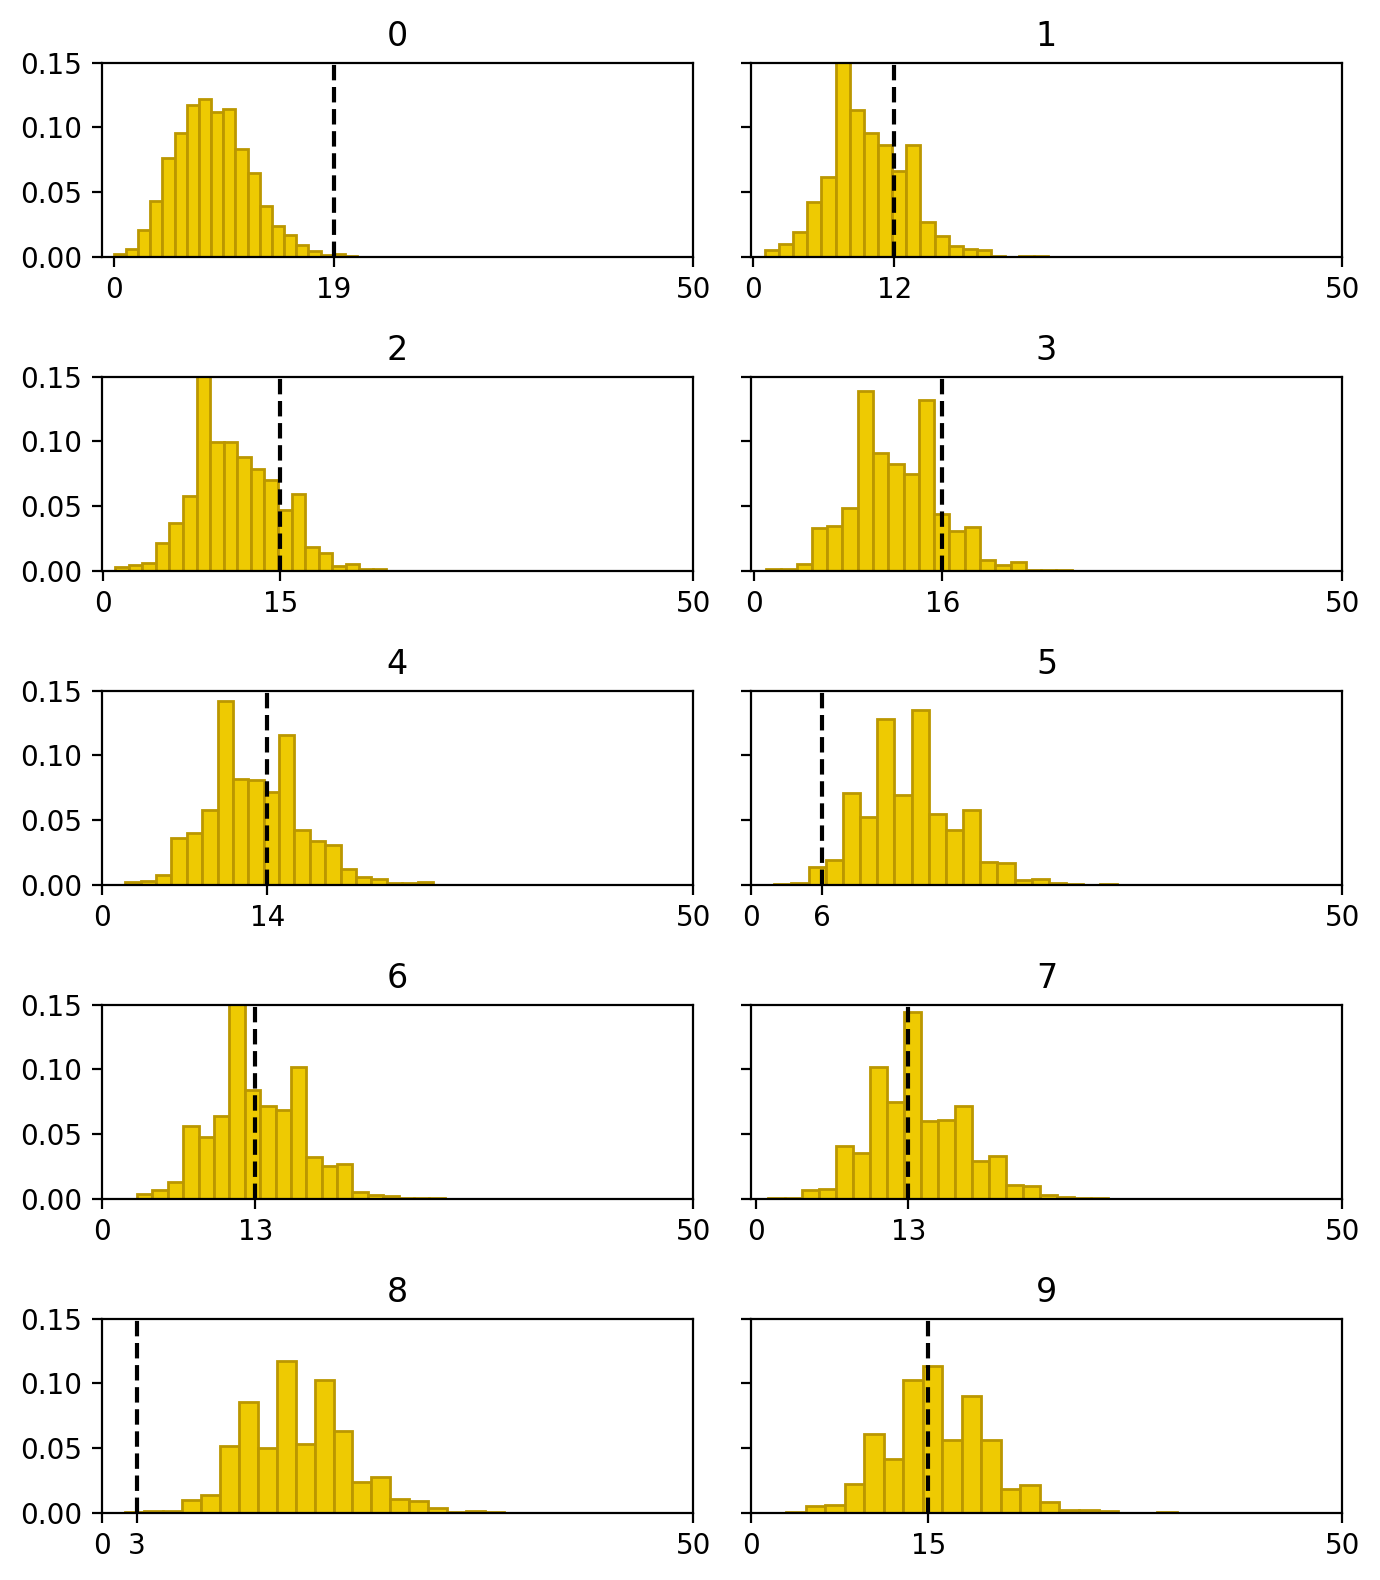

In [63]:
y_sim=params_miles['y_sim']
fig, axes = plt.subplots(5, 2, figsize=(7, 8), sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,color=dark,edgecolor=dark_highlight,density=True)
    ax.set_title(airline_data.index[k])
    tv= int(airline_data['Death rate'].iloc[k]*100)
    ax.plot([tv,tv],[0,0.15],linestyle='--',color='black')
    ax.set_xticks([0,tv,50])
    ax.set_xticklabels([0,tv,50])
    ax.set_ylim([0,0.15])

fig.tight_layout()

plt.show()

### Using model for prediction

In this situation prediction might be a slight more complicated, as it requires from us modifying the generated quantities block
In 1983, there were **20** fatal accidents, **809** passenger deaths, and a death rate of **0.13** per 100 million miles flown. 

In [64]:
miles_1983 = 809/0.13
print(np.round(miles_1983))

6223.0


In [65]:
with open('stan_model/airline_miles_hn_pred.stan', 'r') as file:
    print(file.read())

data {
  int M;            // number of years analyzed
  vector[M] miles;  // number of miles flown each year
  int y[M];         // death rate
  real sigma;       // sigma
  int miles_sim;    // miles flown
}
parameters {
  real<lower=0>theta;
}
model {
  theta ~ normal(0, sigma);
  for (k in 1:M) {
    y[k] ~ poisson(miles[k]*theta);
  }
}
generated quantities {
  int y_sim = poisson_rng(miles_sim*theta);
}





In [66]:
model_pred = stan_utility.compile_model('stan_model/airline_miles_hn_pred.stan')

Using cached StanModel


In [67]:
data = dict(M = len(airline_data),
            miles = airline_data['Miles flown [100 mln miles]'],
            y = dr,
            sigma = sigma,
            miles_sim = int(miles_1983))
fit = model_pred.sampling(data=data, seed=8052020)

y_sim_1983 = fit.extract()['y_sim']

In [68]:
median_y = np.median(y_sim_1983)
cinf_y = az.hpd(y_sim_1983, 0.89)

print('Median of predicted accidents =',median_y)
print('Confidence interval = [',*cinf_y,']')

Median of predicted accidents = 14.0
Confidence interval = [ 6.0 20.0 ]


/home/artur/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


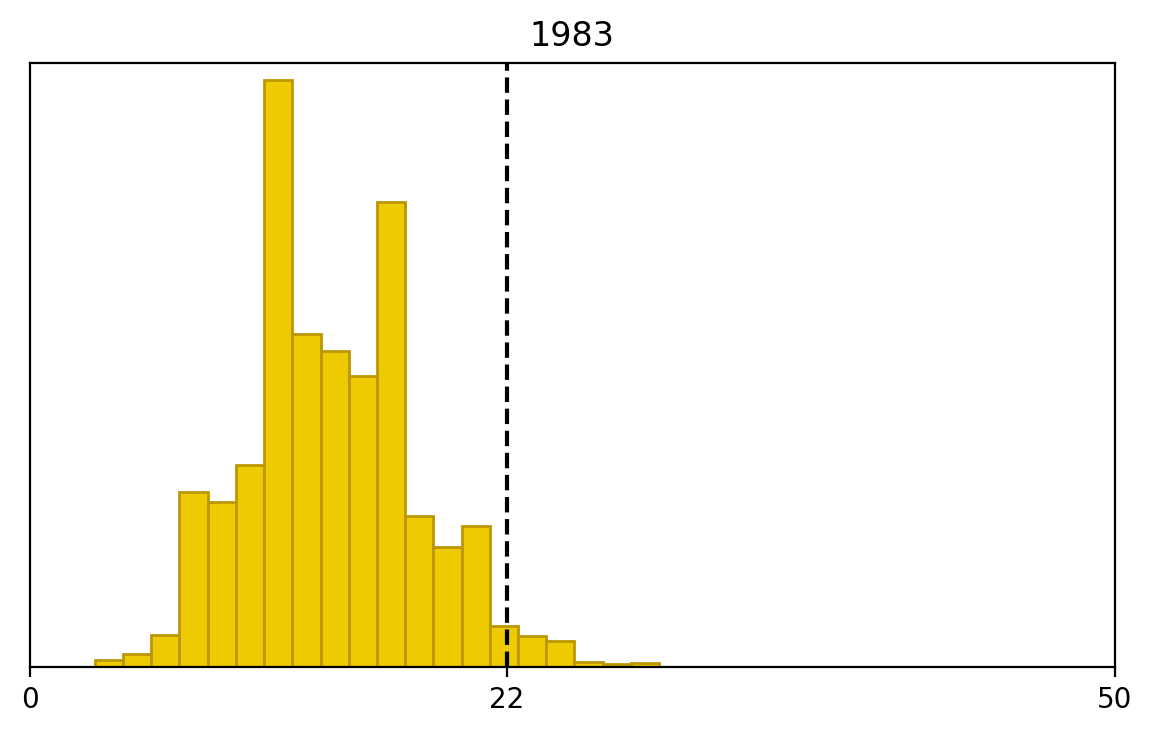

In [74]:
y_sim=params['y_sim']
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(y_sim_1983, bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax.set_title('1983')
tv = 22
ax.plot([tv,tv],[0,0.20],linestyle='--',color='black')
ax.set_yticks([])
ax.set_xticks([0,tv,50])
ax.set_xticklabels(['0',tv,50])
ax.set_ylim([0,0.15])


plt.show()